In [32]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
import random
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis, 
                                            QuadraticDiscriminantAnalysis)
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from scipy import stats
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
from statsmodels.sandbox.stats.multicomp import TukeyHSDResults
from sklearn.metrics import confusion_matrix
import pickle

In [2]:
ds = pd.read_csv('./musk.data', header = None)
# Quitamos las dos primeras columnas ya que son nombres simbólicos
ds = ds.drop([0,1], axis=1)

ds.columns -= 2

output = ds.shape[1]-1 # Columna de output
y = ds[output].values
X = ds.drop(output,axis=1).values
seed = 42
random.seed(seed)
np.random.seed(seed)

In [3]:
X = (X - np.mean(X)) / np.std(X)
X,y = shuffle(X,y)

In [4]:
def principal_component_analisys(X_train, X_test, th):
    th = .85
    alg = PCA()
    X_train = alg.fit_transform(X_train)
    X_test = alg.transform(X_test)
    suma = 0
    var = alg.explained_variance_ratio_
    for i,j in enumerate(var):
        suma += j
        if suma >= th:
            X_train, X_test = (X_train[:,:i + 1], X_test[:,:i + 1])
            break
    return X_train, X_test
        

In [5]:
def exec_MLPC():
    global resultados_train
    global resultados_test
    global res_train
    global res_test
    global model
    global train_indices
    global test_indices
    global etiquetas
    global th
    etiquetas.extend(['MLPR sgd 10 relu',
                 'MLPR sgd 30 relu',
                 'MLPR sgd 50 relu',
                 'MLPR adam 10 relu',
                 'MLPR adam 30 relu',
                 'MLPR adam 50 relu'])
    etiquetas.extend(['MLPR sgd 10 tanh',
                 'MLPR sgd 30 tanh',
                 'MLPR sgd 50 tanh',
                 'MLPR adam 10 tanh',
                 'MLPR adam 30 tanh',
                 'MLPR adam 50 tanh'])
    dicc = [{'hidden_layer_sizes': (10,), 'solver': 'sgd',  
             'activation': 'relu','early_stopping': True, 'max_iter': 1500},
            {'hidden_layer_sizes': (30,), 'solver': 'sgd',  
             'activation': 'relu','early_stopping': True, 'max_iter': 1500},
            {'hidden_layer_sizes': (50,), 'solver': 'sgd',  
             'activation': 'relu','early_stopping': True, 'max_iter': 1500},
            {'hidden_layer_sizes': (10,), 'solver': 'adam', 
             'activation': 'relu','early_stopping': True, 'max_iter': 1500},
            {'hidden_layer_sizes': (30,), 'solver': 'adam', 
             'activation': 'relu','early_stopping': True, 'max_iter': 1500},
            {'hidden_layer_sizes': (50,), 'solver': 'adam', 
             'activation': 'relu','early_stopping': True, 'max_iter': 1500},
            {'hidden_layer_sizes': (10,), 'solver': 'sgd',  
             'activation': 'tanh','early_stopping': True, 'max_iter': 1500},
            {'hidden_layer_sizes': (30,), 'solver': 'sgd',  
             'activation': 'tanh','early_stopping': True, 'max_iter': 1500},
            {'hidden_layer_sizes': (50,), 'solver': 'sgd',  
             'activation': 'tanh','early_stopping': True, 'max_iter': 1500},
            {'hidden_layer_sizes': (10,), 'solver': 'adam', 
             'activation': 'tanh','early_stopping': True, 'max_iter': 1500},
            {'hidden_layer_sizes': (30,), 'solver': 'adam', 
             'activation': 'tanh','early_stopping': True, 'max_iter': 1500},
            {'hidden_layer_sizes': (50,), 'solver': 'adam', 
             'activation': 'tanh','early_stopping': True, 'max_iter': 1500}]

    for i in range(len(dicc)):
        train_indices2 = []
        test_indices2 = []
        for j in range(3):
            for train_index, test_index in kf.split(X):
                X_train, X_test = X[train_index],X[test_index]
                y_train, y_test = y[train_index],y[test_index]
                X_train_pca, X_test_pca = principal_component_analisys(X_train, X_test, th)
                train_indices2.append(train_index)
                test_indices2.append(test_index)
                alg = MLPClassifier(**dicc[i])
                alg.fit(X_train_pca, y_train)
                model.append(alg)
                resultados_train.append(alg.score(X_train_pca, y_train))
                resultados_test.append(alg.score(X_test_pca, y_test))
        res_train = np.hstack((res_train, np.array(resultados_train,ndmin=2).T))
        res_test = np.hstack((res_test, np.array(resultados_test,ndmin=2).T))
        resultados_train = []
        resultados_test = []
        train_indices.append(train_indices2)
        test_indices.append(test_indices2)


In [34]:
%%time
kf = KFold(n_splits=10,shuffle=True)
resultados_train = []
resultados_test = []
model = []
res_train = np.empty((30,0))
res_test = np.empty((30,0))
train_indices = []
test_indices = []
etiquetas = []
th = 0.85
exec_MLPC()

Wall time: 5min 56s


In [7]:
with open('p5_musk-res_test.bin','wb') as file:
    pickle.dump(res_test, file)
with open('p5_musk-train_indices.bin','wb') as file:
    pickle.dump(train_indices, file)
with open('p5_musk-test_indices.bin','wb') as file:
    pickle.dump(test_indices, file)
with open('p5_musk-models.bin','wb') as file:
    pickle.dump(model, file)
with open('p5_musk-etiquetas.bin','wb') as file:
    pickle.dump(etiquetas, file)

In [8]:
with open('p5_musk-res_test.bin','rb') as file:
    res_test = pickle.load(file)
with open('p5_musk-train_indices.bin','rb') as file:
    train_indices = pickle.load(file)
with open('p5_musk-test_indices.bin','rb') as file:
    test_indices = pickle.load(file)
with open('p5_musk-models.bin','rb') as file:
    model = pickle.load(file)
with open('p5_musk-etiquetas.bin','rb') as file:
    etiquetas = pickle.load(file)

FileNotFoundError: [Errno 2] No such file or directory: 'p5-res_test.bin'

In [35]:
np.apply_along_axis(lambda x: stats.shapiro(x)[1], axis=0, arr=res_test)

array([0.84107643, 0.26057765, 0.68017507, 0.41709098, 0.01155144,
       0.43649331, 0.51389164, 0.93685257, 0.25535822, 0.42225567,
       0.50948691, 0.06783661])

In [36]:
print(stats.f_oneway(*zip(*list(res_test))))

F_onewayResult(statistic=117.23504693501015, pvalue=7.827659771115255e-110)


In [37]:
print(stats.kruskal(*zip(*list(res_test))))

KruskalResult(statistic=282.1221122439487, pvalue=5.0747431816169936e-54)


In [38]:
labels = [etiquetas[i] for i in range(res_test.shape[1]) for _ in range(res_test.shape[0])]
arr_test = res_test.flatten('F')
resultados = pairwise_tukeyhsd(arr_test,labels)
# resultados.summary()

In [39]:
#seleccionamos el que tiene mejor media y vemos en el anterior cuales son iguales
best_group = np.argmax(np.mean(res_test, axis = 0))
best_group = etiquetas[int(best_group)]

Figure(720x432)


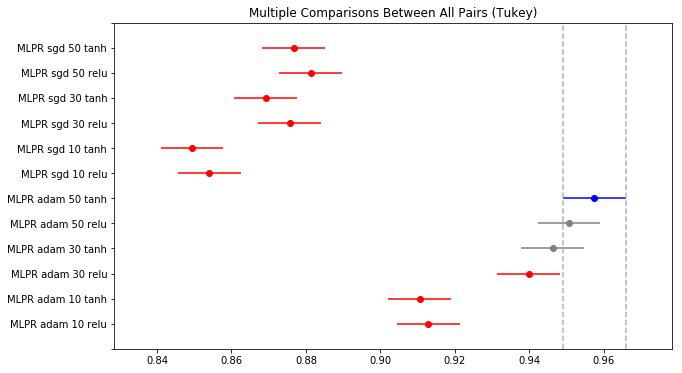

In [40]:
print(resultados.plot_simultaneous(comparison_name=best_group))

In [41]:
resultados = resultados._results_table.data

In [42]:
group1 = resultados[0].index('group1')
group2 = resultados[0].index('group2')
reject = resultados[0].index('reject')
best_groups = []
for row in resultados[1:]:
    if (row[group1] == str(best_group) or row[group2] == str(best_group)) and not row[reject]:
        best_groups.append(row[group1])
        best_groups.append(row[group2])
best_groups.append(best_group)
best_groups = set(best_groups)
sorted(best_groups)

['MLPR adam 30 tanh', 'MLPR adam 50 relu', 'MLPR adam 50 tanh']

In [43]:
def performance_indexes(CM, PositiveClass):
    classNum = len(CM)
    TP = CM[PositiveClass, PositiveClass]
    TN = 0
    FP = 0
    FN = 0
    for real in range(classNum):
        for predicted in range(classNum):
            if (real != PositiveClass and predicted != PositiveClass):
                TN += CM[real, predicted]
            if (real != PositiveClass and predicted == PositiveClass):
                FP += CM[real, predicted]
            if (real == PositiveClass and predicted != PositiveClass):
                FN += CM[real, predicted]
    Sens = TP/(TP+FN)
    Spec = TN/(TN+FP)
    PPV = TP/(TP+FP)
    NPV = TN/(TN+FN)
    ACC = (TP+TN)/(TP+TN+FP+FN)
    return Sens,Spec,PPV,NPV,ACC

In [44]:
for etiqueta in sorted(best_groups):
    i = etiquetas.index(etiqueta)
    m_min = i*30
    m_max = (i+1)*30
    current_model = model[m_min:m_max]
    Sens_l = []
    Spec_l = []
    PPV_l = []
    NPV_l = []
    ACC_l = []
    for idx, test_index in enumerate(test_indices[i]):
        train_index = train_indices[i][idx]
        X_train, y_train = X[train_index], y[train_index]
        X_test, y_test = X[test_index], y[test_index]
        X_train_pca, X_test_pca = principal_component_analisys(X_train, X_test, th)
        y_pred = current_model[idx].predict(X_test_pca)
        CM = confusion_matrix(y_test, y_pred)
        Sens,Spec,PPV,NPV,ACC = performance_indexes(CM,1)
        Sens_l.append(Sens)
        Spec_l.append(Spec)
        PPV_l.append(PPV)
        NPV_l.append(NPV)
        ACC_l.append(ACC)
    print(etiqueta,('-> Sens: {:.2f}, Spec: {:.2f}, ' +
           'PPV: {:.2f}, NPV: {:.2f}, ACC: {:.2f}').format(np.mean(Sens_l),
                                                           np.mean(Spec_l),
                                                           np.mean(PPV_l),
                                                           np.mean(NPV_l),
                                                           np.mean(ACC_l)))

MLPR adam 30 tanh -> Sens: 0.73, Spec: 0.99, PPV: 0.90, NPV: 0.95, ACC: 0.95
MLPR adam 50 relu -> Sens: 0.74, Spec: 0.99, PPV: 0.92, NPV: 0.95, ACC: 0.95
MLPR adam 50 tanh -> Sens: 0.80, Spec: 0.99, PPV: 0.92, NPV: 0.96, ACC: 0.96
